<center><h1>Forecasting Stock Ticker Data Using Python and R</h1></center>

This is just a simple example to show how easy it is to use Python and R together.  The reasons I am using R in addition to Python is because R has such a vast array of available statistical packages that Python currently don't have or not as easily accessible. So I would typically do the data manipulation in Python and then when it comes to the actual statistical heavy-lifting, I use R.   Another reason why I still use R from time to time, is because R's ggplot2 plotting library is awesome.  But there is a Python port of ggplot2 made by [Yhat](http://blog.yhathq.com/posts/ggplot-for-python.html).  But it still has some ways to go to be good for production use.

After you have Python/IPython notebook installed and set up, you just need to install R first and then rpy2.  In this example, it is assumed you have installed the [Pandas](http://pandas.pydata.org/) library.

You install R by going [here](http://www.r-project.org/) or do a: sudo apt-get install r-base if you're on a Ubuntu-based machine.  Then install rpy2 by executing pip at the console/terminal: pip install rpy2

<strong>NOTE:</strong> On Windows 7, it'll be hit or miss.  At least for me, I would get weird unformatted output to the IPython notebook from R on a Windows 7 machine.  rpy2's own website also state they do not fully support Windows, which is too bad since I have to use Windows at work.  But generating charts still worked on Windows and you can still get formatted output from the terminal console that you've launched ipython notebook server from.

My setup:
- Python 3.4 installed using Anaconda distribution using miniconda3 [installer](http://conda.pydata.org/miniconda.html).  Who wants to wait for your favorite libraries to compile?  Not me.  Use Anaconda!
- Xubuntu 14.10
- IPython version 3.0rc1
- R version 3.1.1 (installed via: sudo apt-get install r-base)
- rpy2 version 2.5.4 (installed via: pip install rpy2 because rpy2 is not available in the Anaconda distribution)

## Obtain stock ticker data

In [1]:
import pandas.io.data as web
from datetime import datetime
import pandas as pd

ticker = 'HMC'
start = datetime(2013, 1, 1)
end = datetime(2014, 12, 19)

df=web.DataReader(ticker, 'yahoo', start, end)

In [2]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,37.69,38.40,37.69,38.36,1223600,38.18
2013-01-03,37.96,38.30,37.80,37.89,1054500,37.71
2013-01-04,37.32,37.79,37.31,37.75,1867500,37.57
2013-01-07,36.82,37.34,36.65,37.16,1531200,36.98
2013-01-08,36.68,36.74,36.18,36.38,1058400,36.21


In [3]:
df.reset_index(level=0, inplace=True)  # R's data frame doesn't like it when the index is a date so convert date to column

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2013-01-02,37.69,38.40,37.69,38.36,1223600,38.18
1,2013-01-03,37.96,38.30,37.80,37.89,1054500,37.71
2,2013-01-04,37.32,37.79,37.31,37.75,1867500,37.57
3,2013-01-07,36.82,37.34,36.65,37.16,1531200,36.98
4,2013-01-08,36.68,36.74,36.18,36.38,1058400,36.21


### Load the rpy2 extension so that we can interact with R

In [5]:
%load_ext rpy2.ipython

### Pass the pandas dataframe to R as an input.  Other options can be found [here](http://ipython.org/ipython-doc/stable/config/extensions/rmagic.html).

In [6]:
%R -i df

## Now plot the stock ticker Closing price using R's ggplot2 library

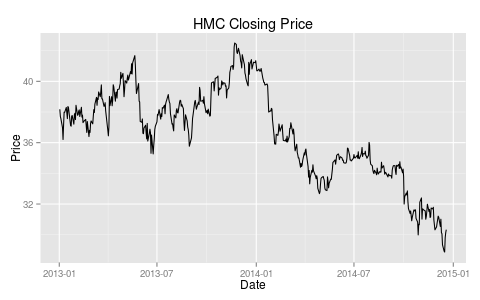

In [7]:
%%R -w 480 -h 300 -u px # Set size of chart.  Instead of px, you can also choose 'in', 'cm', or 'mm'
df = as.data.frame(df)  # ensure dataframe that was passed in from Python will be R's dataframe type
library(ggplot2)
p = ggplot(df, aes(df$Date, df$Adj.Close))
p = p + 
    geom_line() +
    ggtitle("HMC Closing Price") +
    xlab("Date") +
    ylab("Price")
print(p)

## Let's forecast using R's forecast package

In [8]:
%%R
library(forecast)
HoltWinters(df$Adj.Close)  # We're usign Holt-Winters, but there are several other models to choose from

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 5.7 

Error in decompose(ts(x[1L:wind], start = start(x), frequency = f), seasonal) : 
  time series has no or less than 2 periods


#### Error message just means no seasonality was detected.  So we will not use gamma in our model.

## Let's output a summary of our H-W model

In [9]:
%%R
hwm = HoltWinters(df$Adj.Close, gamma=FALSE)
hwf = forecast.HoltWinters(hwm, h=20)  # forecast out to 20 time periods
summary(hwf)


Forecast method: HoltWinters

Model Information:
Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = df$Adj.Close, gamma = FALSE)

Smoothing parameters:
 alpha: 0.9195088
 beta : 0.04376709
 gamma: FALSE

Coefficients:
         [,1]
a 30.30802479
b -0.03354635

Error measures:
                     ME      RMSE       MAE        MPE     MAPE     MASE
Training set 0.02190934 0.4881052 0.3700685 0.06958344 1.013572 1.019427
                      ACF1
Training set -0.0005973031

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
498       30.27448 29.64894 30.90001 29.31781 31.23115
499       30.24093 29.37391 31.10795 28.91494 31.56692
500       30.20739 29.13827 31.27650 28.57231 31.84246
501       30.17384 28.92227 31.42541 28.25973 32.08795
502       30.14029 28.71788 31.56270 27.96491 32.31568
503       30.10675 28.52096 31.69253 27.68149 32.53200
504       30.07320 28.32903 31.81737 27.40572 32.74068
505       30.03965 2

#### Above is our point forecasts and their respective 80th- and 95th-percentile confidence intervals

## Now let's plot the actual data and forecast together with confidence intervals

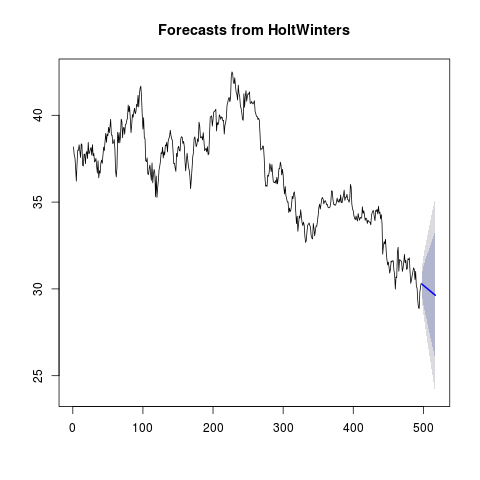

In [10]:
%%R
plot.forecast(hwf)

### We're done!